<a href="https://colab.research.google.com/github/aleksandr-del/kaggle-competitions/blob/main/season_3_episode_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vector Borne Disease Prediction

![image](https://storage.googleapis.com/kaggle-datasets-images/2057766/3413944/577cbf7678c2cdb8db1e51cbb84f0a19/dataset-cover.jpg?t=2022-04-06-02-56-16)


Данные (обучающая и тестовая выборки) для этого [соревнования](https://www.kaggle.com/competitions/playground-series-s3e13/data) были сгенерированы нейронной сетью, обученной на исходных данных [Vector Borne Disease Dataset](https://www.kaggle.com/datasets/richardbernat/vector-borne-disease-prediction). Распределения признаков близко к исходным.

`Vector Borne Disease` - `трансмиссивные болезни`. Заразные болезни, возбудители которых передаются кровососущими членистоногими (насекомыми и клещами). Трансмиссивные болезни включают более 200 нозологических форм, вызываемых вирусами, бактериями, риккетсиями, простейшими и гельминтами. Часть из них передаётся только с помощью кровососущих переносчиков, часть различными способами, в том числе и трансмиссивно (например, туляремия, заражение которой происходит при укусах комаров и клещей, а также при порезах в процессе снятия шкурок с больных животных).

Результаты соревнования будут оцениваться по метрике [MPA@3](https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code/notebook). В каждом submission для каждого `id` может быть указано до трех предсказанных болезней (разделенных пробелами), и чем раньше в последовательности из трех предсказаний будет указан верный ответ, тем выше будет значение метрики.


## Загрузка и анализ данных

Импортируем необходимые библиотеки, модули и функкции:

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("muted")

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

Загрузим обучающую, тестовую выборки и шаблон файла для submission:

In [4]:
from google.colab import files

In [ ]:
files.upload()

In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 /root/.kaggle/kaggle.json

In [9]:
! kaggle competitions download -c playground-series-s3e13

  0% 0.00/20.5k [00:00<?, ?B/s]
100% 20.5k/20.5k [00:00<00:00, 11.2MB/s]


Распакуем архивный файл:

In [10]:
! unzip playground-series-s3e13.zip -d data

Archive:  playground-series-s3e13.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


Сохраним обучающую выборку в переменной `df` и выведим первые 5 строк датафрейма:

In [11]:
df = pd.read_csv('/content/data/train.csv', index_col=[0])

In [12]:
df.head()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


Общая информация об обучающей выборке:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 707 entries, 0 to 706
Data columns (total 65 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sudden_fever           707 non-null    float64
 1   headache               707 non-null    float64
 2   mouth_bleed            707 non-null    float64
 3   nose_bleed             707 non-null    float64
 4   muscle_pain            707 non-null    float64
 5   joint_pain             707 non-null    float64
 6   vomiting               707 non-null    float64
 7   rash                   707 non-null    float64
 8   diarrhea               707 non-null    float64
 9   hypotension            707 non-null    float64
 10  pleural_effusion       707 non-null    float64
 11  ascites                707 non-null    float64
 12  gastro_bleeding        707 non-null    float64
 13  swelling               707 non-null    float64
 14  nausea                 707 non-null    float64
 15  chills

В обучающей выборке 707 наблюдений, 63 признака, метки классов в столбце `prognosis`. Пропуски отсутствуют.

В переменной `X` сохраним список признаков:

In [14]:
X = df.drop(columns='prognosis').columns.tolist()

Создадим словарь для преобразования строковых меток класса в числовые:

In [15]:
labels_dict = dict(zip(df['prognosis'].unique(), range(df['prognosis'].nunique())))

In [16]:
labels_dict

{'Lyme_disease': 0,
 'Tungiasis': 1,
 'Zika': 2,
 'Rift_Valley_fever': 3,
 'West_Nile_fever': 4,
 'Malaria': 5,
 'Chikungunya': 6,
 'Plague': 7,
 'Dengue': 8,
 'Yellow_Fever': 9,
 'Japanese_encephalitis': 10}

Добавим к обучающей выборке столбец с числовыми метками классов:

In [17]:
df['label'] = df['prognosis'].replace(labels_dict)

Проверим количество уникальных значений для каждого из признаков:

In [18]:
for x in X:
    print(f'У признака {x.upper()} {df[x].nunique()} уникальных значений.')

У признака SUDDEN_FEVER 2 уникальных значений.
У признака HEADACHE 2 уникальных значений.
У признака MOUTH_BLEED 2 уникальных значений.
У признака NOSE_BLEED 2 уникальных значений.
У признака MUSCLE_PAIN 2 уникальных значений.
У признака JOINT_PAIN 2 уникальных значений.
У признака VOMITING 2 уникальных значений.
У признака RASH 2 уникальных значений.
У признака DIARRHEA 2 уникальных значений.
У признака HYPOTENSION 2 уникальных значений.
У признака PLEURAL_EFFUSION 2 уникальных значений.
У признака ASCITES 2 уникальных значений.
У признака GASTRO_BLEEDING 2 уникальных значений.
У признака SWELLING 2 уникальных значений.
У признака NAUSEA 2 уникальных значений.
У признака CHILLS 2 уникальных значений.
У признака MYALGIA 2 уникальных значений.
У признака DIGESTION_TROUBLE 2 уникальных значений.
У признака FATIGUE 2 уникальных значений.
У признака SKIN_LESIONS 2 уникальных значений.
У признака STOMACH_PAIN 2 уникальных значений.
У признака ORBITAL_PAIN 2 уникальных значений.
У признака N

У всех признаков по 2 уникальных значений. Получается, что все признаки категориальные со следующими значениями: `1` - **у пациента симптом наблюдается**, `0` - **у пациента симптом отсутствует**.

Посмотрим на распределение классов в обучающей выборке:

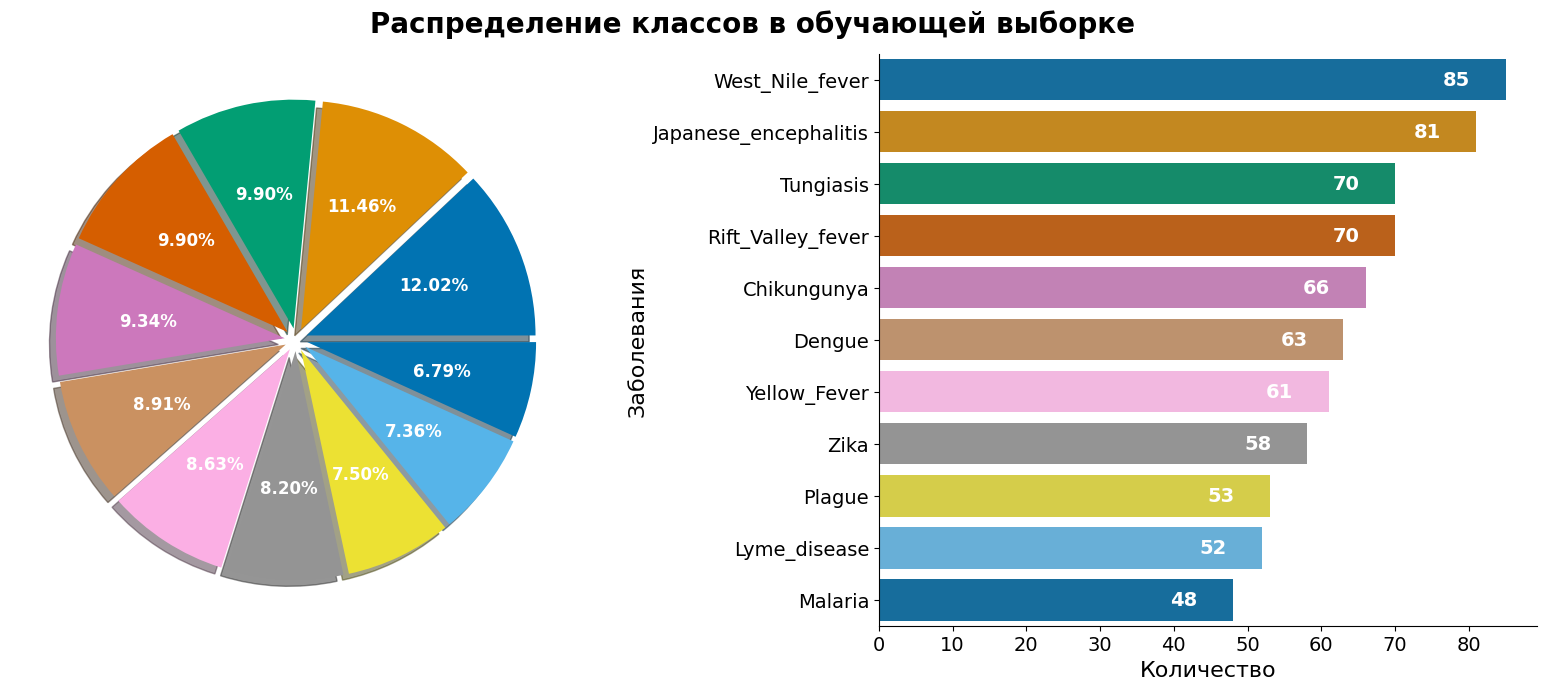

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax = ax.flatten()

ax[0].pie(df['prognosis'].value_counts(ascending=False), 
          shadow=True, 
          autopct='%1.2f%%',
          explode=[0.05] * len(df['prognosis'].unique()),
          textprops={'size': 12, 'color': 'white', 'weight': 'bold'},
          colors=sns.color_palette('colorblind', len(df['prognosis'].unique())))

sns.countplot(y='prognosis', 
              data=df, 
              order=df['prognosis'].value_counts(ascending=False).index,
              ax=ax[1],
              palette='colorblind')

ax[1].bar_label(container=ax[1].containers[0],
             labels=df['prognosis'].value_counts(ascending=False).values,
             padding=-45, color='white',
             fontsize=14, fontweight='bold')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0, fontsize=14)
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=14)

plt.ylabel('Заболевания', fontsize=16)
plt.xlabel('Количество', fontsize=16)
plt.suptitle('Распределение классов в обучающей выборке', fontsize=20, fontweight='bold')
sns.despine(bottom=False)
plt.tight_layout()
plt.show()

Посмотрим, какие симптомы больше или меньше проявляются или вовсе не проявляются у каждой болезни. Для этого посчитаем общее количество наблюдений и количество симптомов у каждого класса:

In [22]:
total = df.groupby('prognosis')[X].count().T.reset_index(names='prognosis')

In [23]:
summa = df.groupby('prognosis')[X].sum().T.reset_index(names='prognosis')

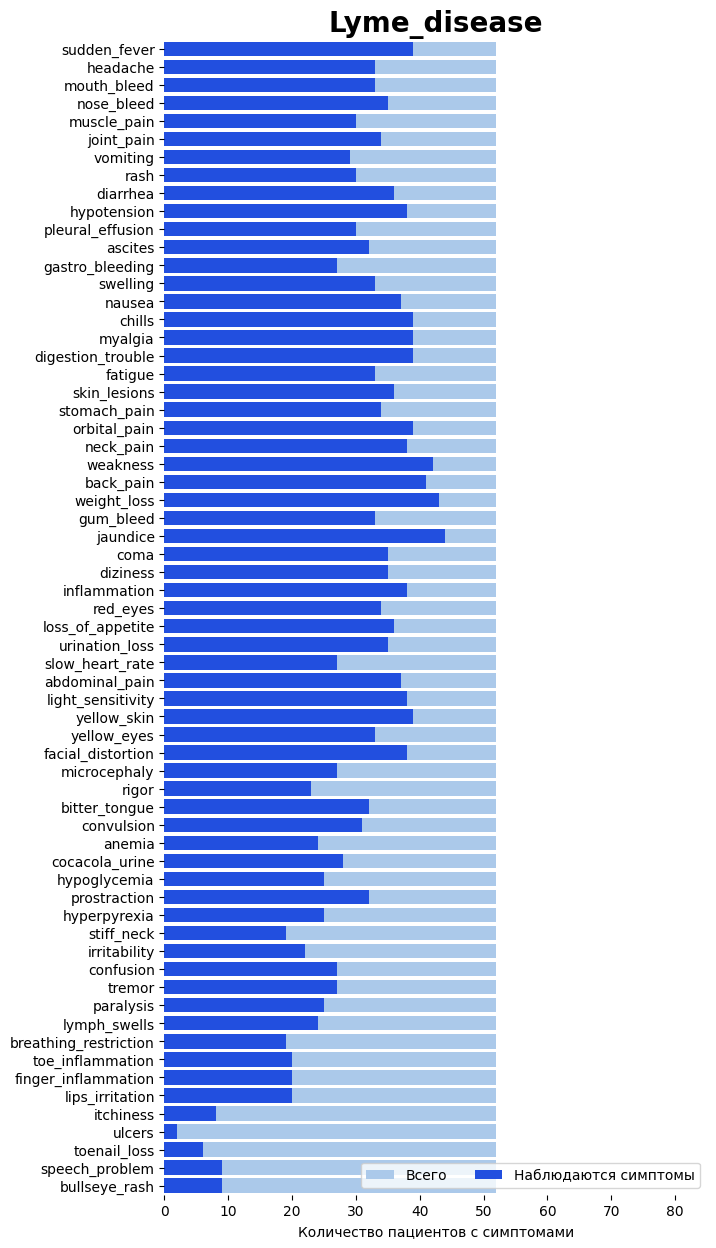

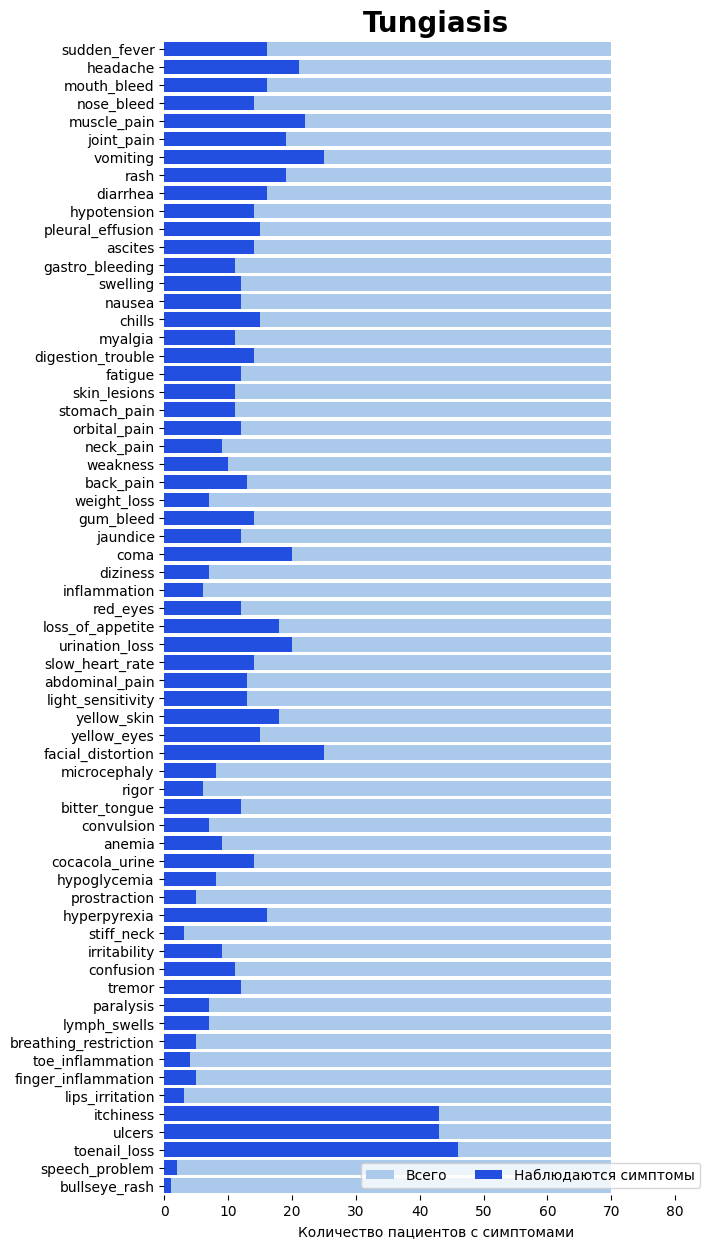

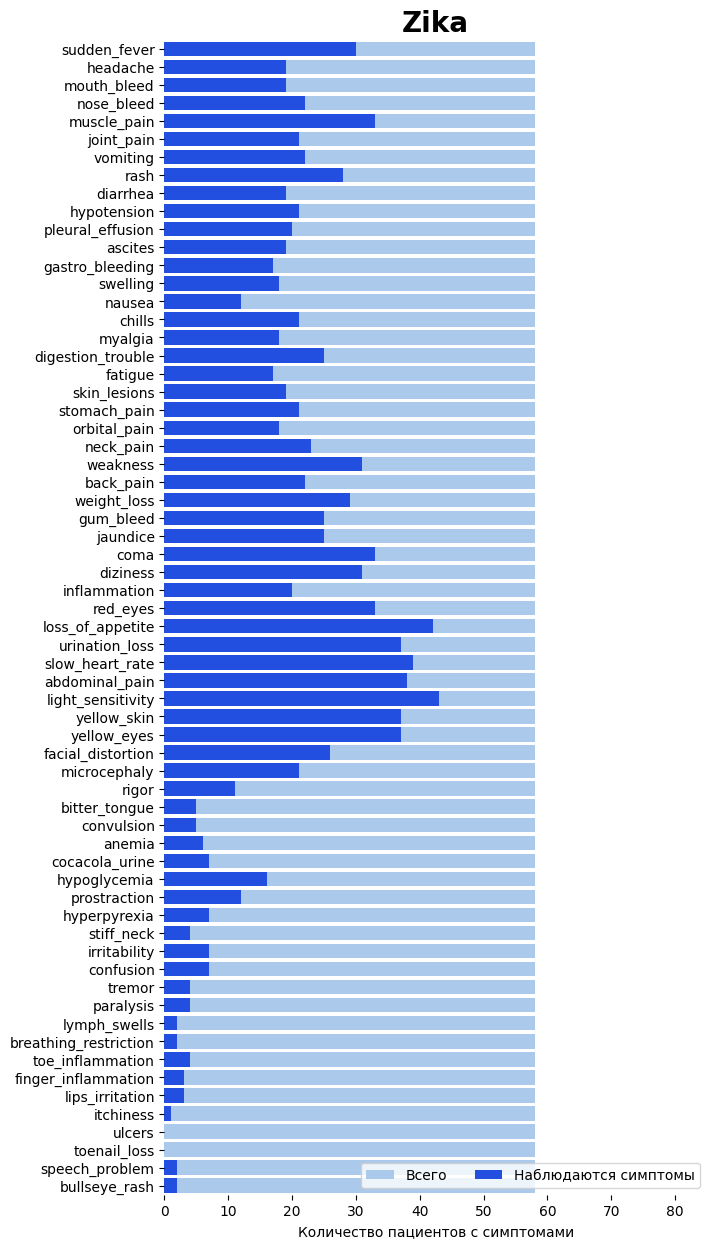

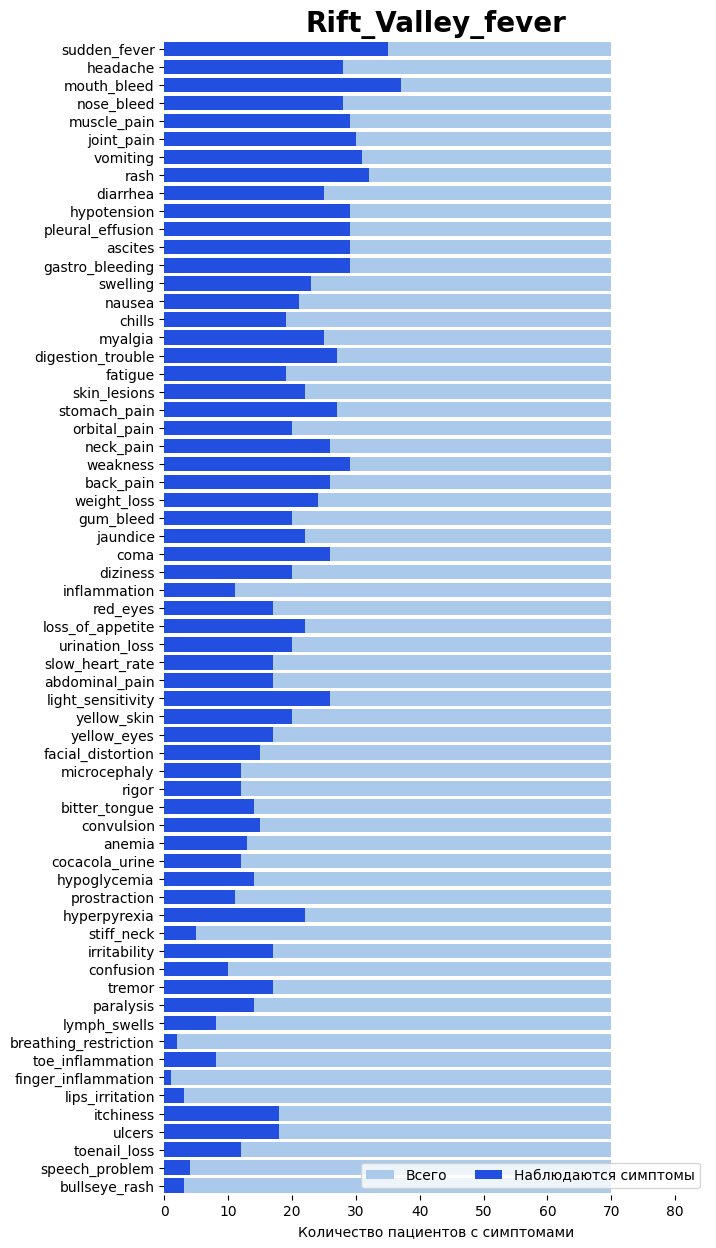

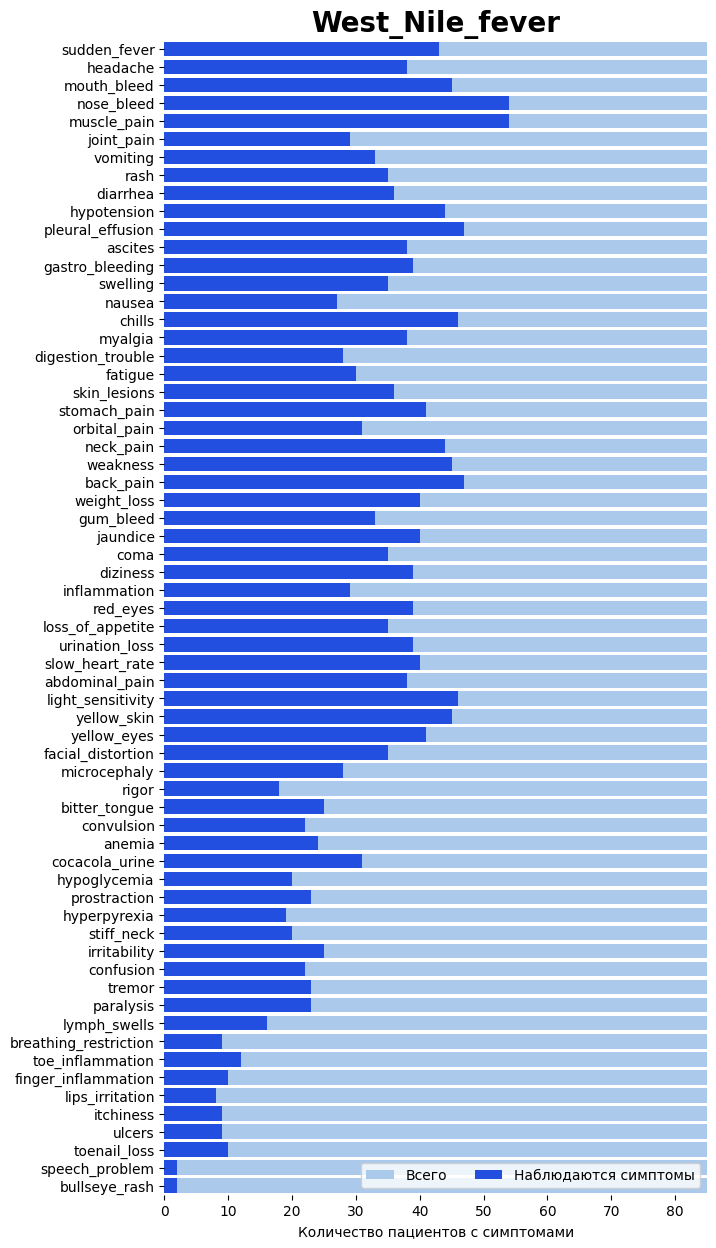

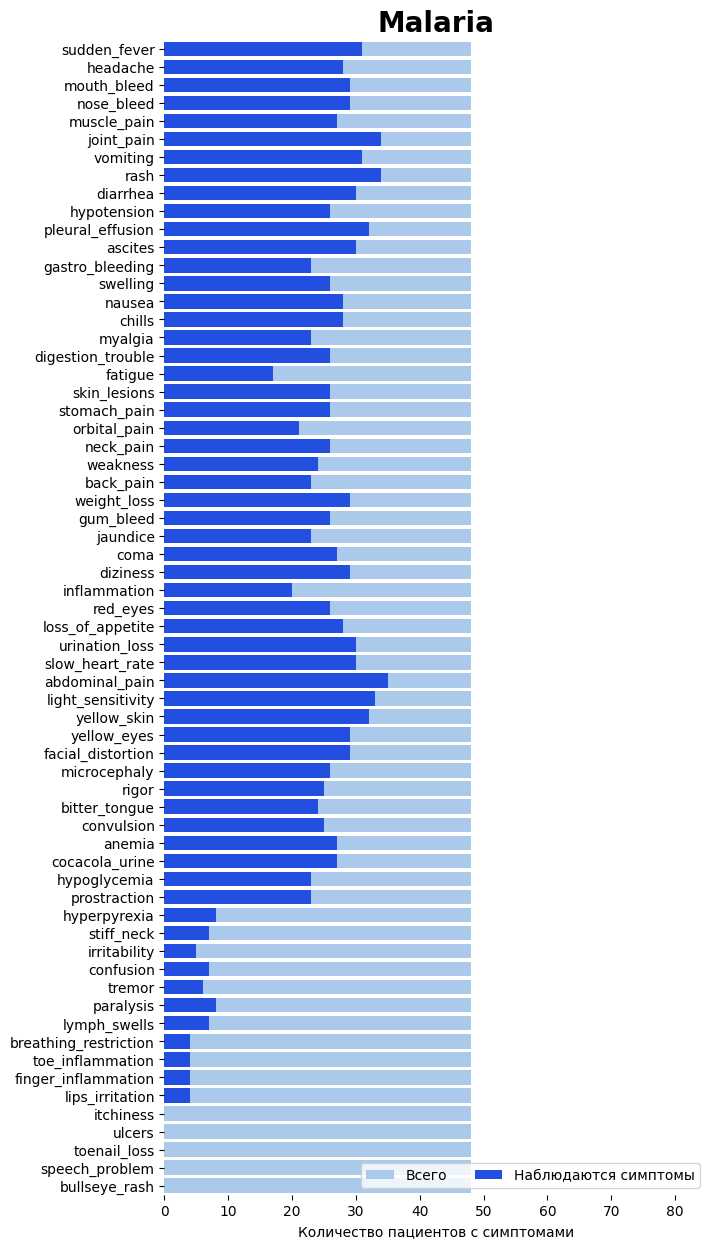

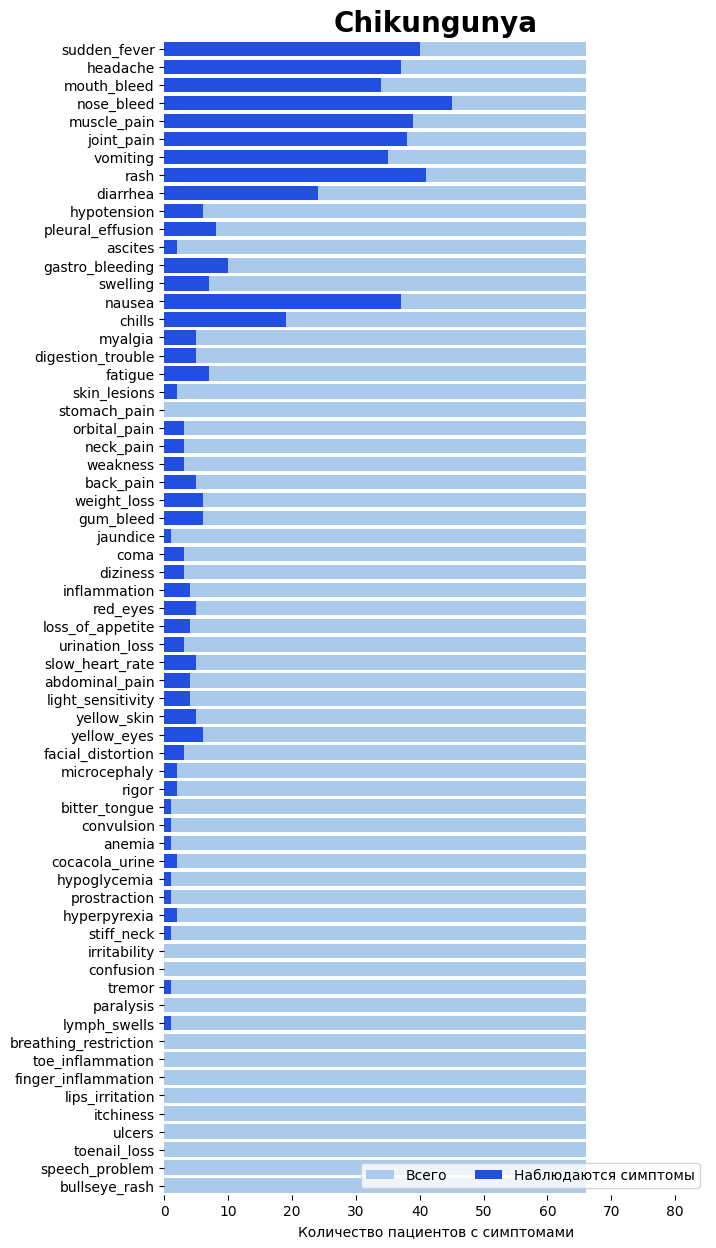

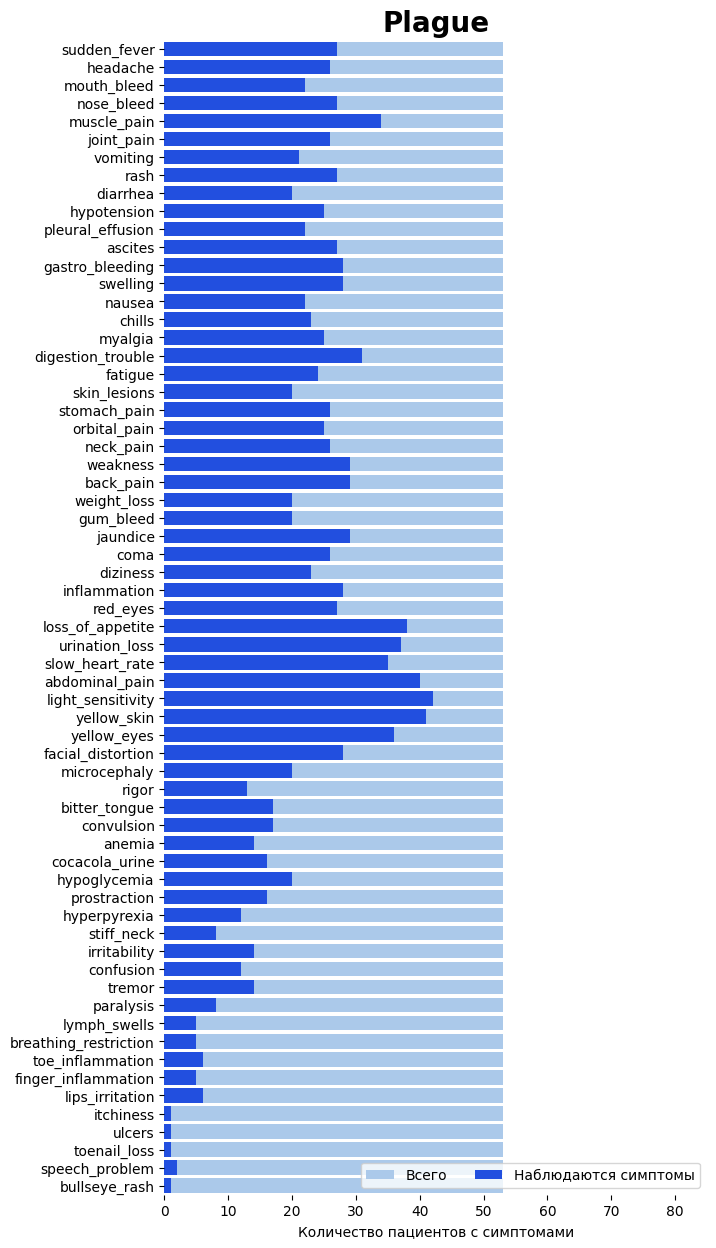

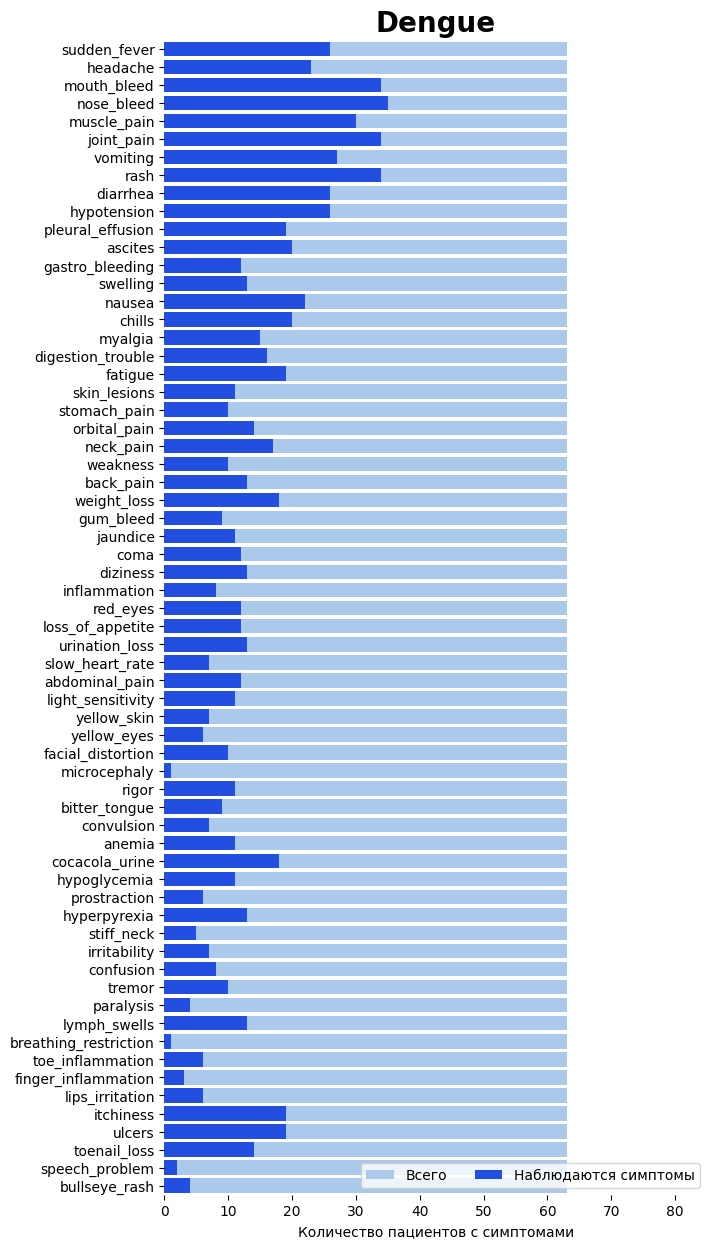

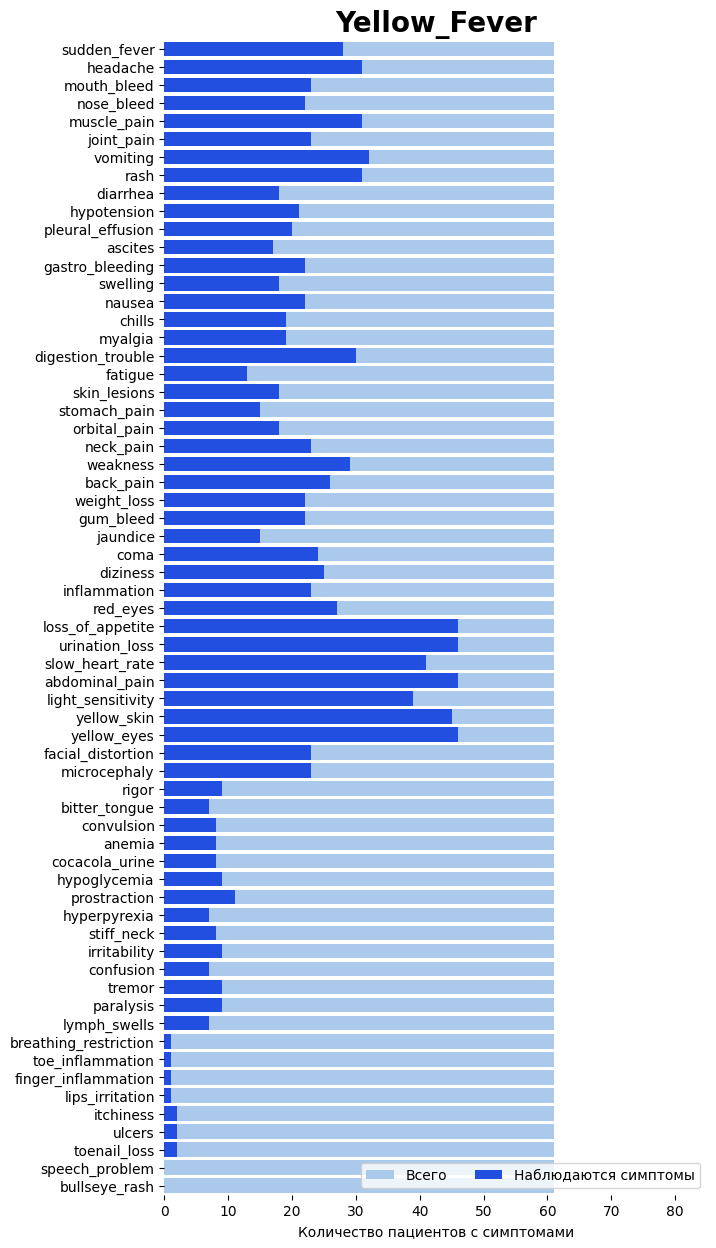

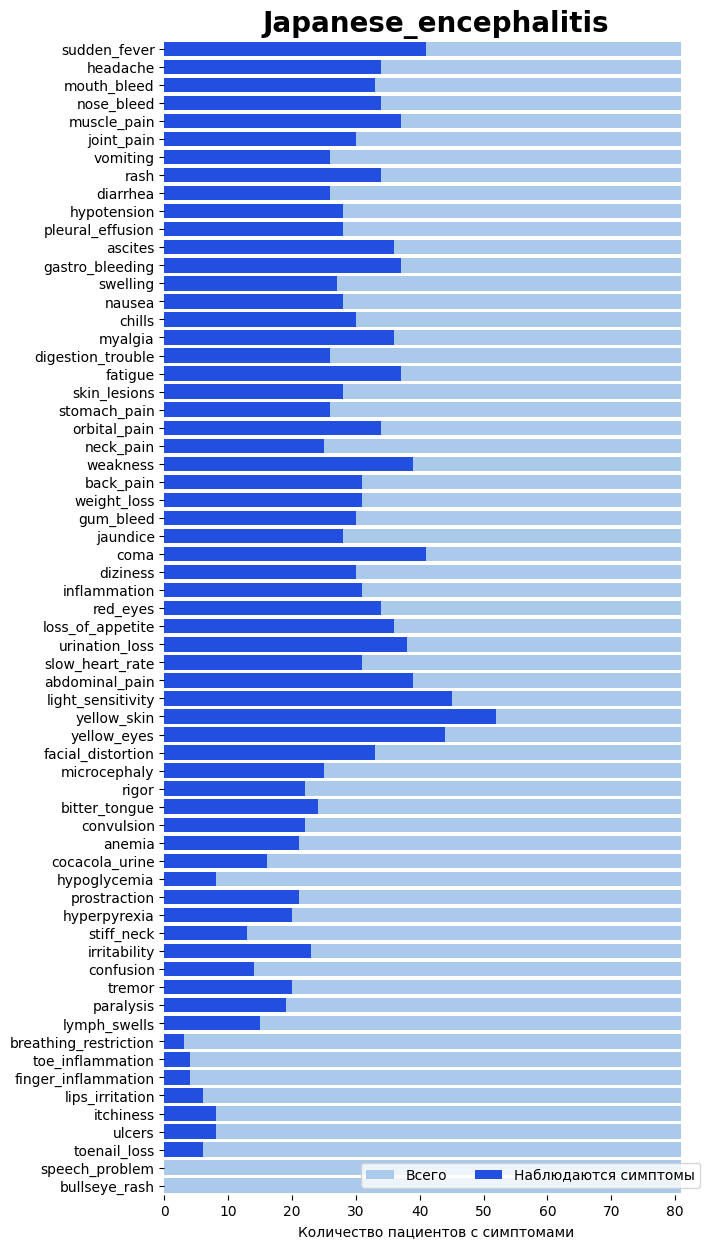

In [24]:
for i in df['prognosis'].unique():
    _, ax = plt.subplots(figsize=(7, 15))

    sns.set_color_codes('pastel')
    sns.barplot(x=i, 
                y='prognosis', 
                data=total, 
                label='Всего', 
                color='b')

    sns.set_color_codes('bright')
    sns.barplot(x=i, 
                y='prognosis', 
                data=summa, 
                label='Наблюдаются симптомы', 
                color='b')


    ax.legend(ncol=2, loc='lower right', frameon=True)
    ax.set(xlim=(0, 85), 
           ylabel='', 
           xlabel='Количество пациентов с симптомами')
    ax.set_title(label=i, loc='center', fontdict={'fontsize': 20, 
                                                  'fontweight': 'bold'})
    sns.despine(left=True, bottom=True)
    
    plt.show()
    print()

## Обучение

### Случайный лес

Создадим сетку гиперпараметров алгоритма Случайного леса:

In [50]:
parameters = {'n_estimators': [100, 1000, 2000],
              'criterion': ['gini', 'log_loss', 'entropy'],
              'max_depth': [2, 4, 8, 16, 32],
              'random_state': [0, 42]}

Инициализируем объекта класса `GridSearchCV`:

In [51]:
lr_gs = GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=parameters,
                     cv=5,
                     scoring='neg_log_loss',
                     n_jobs=2)

Переберем гиперпараметры алгоритма:

In [ ]:
lr_gs.fit(df[X], df['label'])

Лучшее значение `log_loss` модели Случайного леса:

In [53]:
-lr_gs.best_score_

1.8849706630222065

Лучшие гиперпараметры:

In [54]:
lr_gs.best_params_

{'criterion': 'gini', 'max_depth': 16, 'n_estimators': 2000, 'random_state': 0}

#### Submission для соревнования

Обучим алгоритм Случайного леса на всей обучащей выборке с использование лучших гиперпараметров: 

In [55]:
best_rf = RandomForestClassifier(**lr_gs.best_params_)

In [ ]:
best_rf.fit(df[X], df['label'])

Загрузим тестовую выборку, сохраним ее в переменной `test` и выведим первые 5 строк:

In [137]:
test = pd.read_csv('/content/data/test.csv')

In [138]:
test.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,708,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,709,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,710,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,711,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Общая информация о тестовой выборке:

In [139]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 65 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     303 non-null    int64  
 1   sudden_fever           303 non-null    float64
 2   headache               303 non-null    float64
 3   mouth_bleed            303 non-null    float64
 4   nose_bleed             303 non-null    float64
 5   muscle_pain            303 non-null    float64
 6   joint_pain             303 non-null    float64
 7   vomiting               303 non-null    float64
 8   rash                   303 non-null    float64
 9   diarrhea               303 non-null    float64
 10  hypotension            303 non-null    float64
 11  pleural_effusion       303 non-null    float64
 12  ascites                303 non-null    float64
 13  gastro_bleeding        303 non-null    float64
 14  swelling               303 non-null    float64
 15  nausea

В тестовой выборке 303 наблюдения, пропусков нет.

Предскажем вероятности принадлежности к классам 11 болезней:

In [140]:
test_proba = best_rf.predict_proba(test[X])

Посмотрим на вероятности классов первых 5 наблюдений тестовой выборки:

In [141]:
test_proba[:5]

array([[0.0145    , 0.12019674, 0.11482143, 0.19473674, 0.09864826,
        0.0205    , 0.06857426, 0.033     , 0.13986824, 0.06257143,
        0.1325829 ],
       [0.0045    , 0.00965447, 0.0185    , 0.08727216, 0.0315462 ,
        0.09516482, 0.12557345, 0.2501208 , 0.30548659, 0.04959856,
        0.02258296],
       [0.087     , 0.066     , 0.0925    , 0.1135    , 0.1965    ,
        0.0515    , 0.02791667, 0.0505    , 0.06858333, 0.106     ,
        0.14      ],
       [0.0275    , 0.12951852, 0.0820119 , 0.14068132, 0.08121635,
        0.07058333, 0.04113294, 0.02957115, 0.08972484, 0.09143465,
        0.216625  ],
       [0.08      , 0.0715    , 0.1185    , 0.0745    , 0.135     ,
        0.2025    , 0.011     , 0.076     , 0.049     , 0.088     ,
        0.094     ]])

Создадим список болезней в том порядке, в каком мы записывали числовые метки классов:

In [142]:
diseases = np.array([x  for x in labels_dict.keys()])
diseases

array(['Lyme_disease', 'Tungiasis', 'Zika', 'Rift_Valley_fever',
       'West_Nile_fever', 'Malaria', 'Chikungunya', 'Plague', 'Dengue',
       'Yellow_Fever', 'Japanese_encephalitis'], dtype='<U21')

В тестовой выборке создадим столбец `prognosis` и сохраним в нем 3 наиболее вероятных болезни для каждого наблюдения. По условиям соревнования между названиями болезней должен быть пробел:

In [143]:
test['prognosis'] = list(map(lambda x: ' '.join(diseases[np.argsort(-x)[:3]]), test_proba))

In [144]:
test['prognosis'][:5]

0       Rift_Valley_fever Dengue Japanese_encephalitis
1                            Dengue Plague Chikungunya
2    West_Nile_fever Japanese_encephalitis Rift_Val...
3    Japanese_encephalitis Rift_Valley_fever Tungiasis
4                         Malaria West_Nile_fever Zika
Name: prognosis, dtype: object

Запишем таблицу в файл для отправки решения на Kaggle:

In [145]:
test[['id', 'prognosis']].to_csv('submission.csv', index=None)

Промежуточный результат на тестовой выборке `MAP@3=0.38741`